# 1

In [1]:
cd D:\Janis\Desktop\资产定价（投资学）\data

D:\Janis\Desktop\资产定价（投资学）\data


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
d_ipo = pd.read_sas('IPOs_1996_2000.sas7bdat')
d_rcm = pd.read_sas('Recommendation.sas7bdat')

In [4]:
#按announce date排序，并去掉重复的CUSIP，就能得到股票首次被anno的日期的列表
d_rcm_by_date = d_rcm.sort_values(by = 'ANNDATS', ascending=True).drop_duplicates(subset=['CUSIP'], keep='first')
#把推荐等级IRECCD从b string转换成int，方便后续筛选
d_rcm_by_date['IRECCD'] = [int(s.decode()) for s in d_rcm_by_date['IRECCD']]

In [5]:
#加入Offer_Date 股票发行日
d_rcm_by_date = pd.merge(pd.DataFrame(d_ipo, columns=['CUSIP', 'Offer_Date']), pd.DataFrame(d_rcm_by_date, columns=['CUSIP', 'IRECCD', 'ANNDATS']), on = 'CUSIP')
#后续分别以第一次anno、Offer_Date+25为event
d_rcm_by_date

,CUSIP,Offer_Date,IRECCD,ANNDATS
0,b'78668010',1996-01-11,1,1996-02-23
1,b'65539810',1996-01-18,2,1996-05-23
2,b'75642210',1996-01-22,2,1996-02-21
3,b'02109K10',1996-01-23,1,1996-03-19
4,b'30271210',1996-01-23,1,1996-02-27
...,...,...,...,...
1846,b'84749R10',2000-12-07,2,2001-01-02
1847,b'41690610',2000-12-07,1,2001-02-26
1848,b'02888410',2000-12-07,1,2001-01-03
1849,b'37246C10',2000-12-11,2,2001-04-20


# 4

In [6]:
d_ret = pd.read_sas('AssignmentReturns.sas7bdat')
d_mret = pd.read_sas('Market_returns.sas7bdat')

In [7]:
#d_merge_ret中存储全部日期、全部股票的return数据
d_merge_ret = pd.merge(pd.DataFrame(d_ret, columns=['CUSIP', 'PERMNO', 'RET', 'DATE']), pd.DataFrame(d_mret, columns=['date', 'VWRETD']), left_on = "DATE", right_on = "date")
d_merge_ret = d_merge_ret.drop(columns = 'date')
#计算market adjusted returns
d_merge_ret['mar'] = d_merge_ret['RET'] - d_merge_ret['VWRETD']

In [8]:
#d_calc中存储股票编号、mar、IRECCD
d_calc = pd.merge(pd.DataFrame(d_merge_ret, columns = ['CUSIP', 'DATE', 'mar']), pd.DataFrame(d_rcm_by_date, columns = ['CUSIP', 'IRECCD', 'ANNDATS']), left_on = "CUSIP", right_on = "CUSIP")
#计算股票mar日期和第一次anno的相差天数delta，并转换为int
#第一个event
d_calc['delta'] = (d_calc['DATE'] - d_calc['ANNDATS']).dt.days
#因题目要求计算-5~5天内的，去除所有时间范围以外的数据
d_calc = d_calc.drop(d_calc[abs(d_calc['delta']) > 5].index)
#后续按IRECCD分组，按delta打印表格，所以可以去除日期
#相当于中心化操作
d_calc = d_calc.drop(columns = ['DATE', 'ANNDATS'])
d_calc


,CUSIP,mar,IRECCD,delta
27,b'78668010',-0.008855,1,-3
28,b'78668010',0.009342,1,-2
29,b'78668010',-0.024849,1,-1
30,b'78668010',-0.000660,1,0
31,b'78668010',-0.019343,1,3
...,...,...,...,...
1025184,b'76122Q10',0.046886,1,-1
1025185,b'76122Q10',-0.029103,1,0
1025186,b'76122Q10',-0.010368,1,1
1025187,b'76122Q10',0.034579,1,2


In [9]:
def calc(k):
    #储存题目要求的输出表格
    d_ans = pd.DataFrame(columns = ['days', 'amar', 't', 'n'])
    d_ans['days'] = range(-5,6)
    d_ans.loc[:,:] = 0
    #初始化days为-5~5
    d_ans['days'] = range(-5,6)
    #i计数目前处理到第几列，实际上就是row.index
    i = 0
    #对表格进行循环
    for row in d_ans.iterrows():
        #条件k是按推荐等级分组，delta == days是按距离event天数分组，取出符合条件的mar序列
        d_temp = d_calc[(k) & (d_calc['delta'] == row[1]['days'])]['mar']
        #求average mar
        d_ans.loc[i, 'amar'] = d_temp.dropna().mean()
        #求符合条件的个数n
        df_bool = (k) & (d_calc['delta'] == row[1]['days'])
        d_ans.loc[i, 'n'] = df_bool.sum()
        #对取出的mar序列做t检验，原假设μ = 0
        #注意ttest_1samp输出的[t, p]，这里取t
        d_ans.loc[i, 't'] = ttest_1samp(d_temp.dropna(), 0)[0]
        i = i+1
    return d_ans
#分别传入对IRECCD的判断，以分成{1}，{2}，{3，4，5}三组
print(calc(d_calc['IRECCD'] == 1))
print(calc(d_calc['IRECCD'] == 2))
print(calc(d_calc['IRECCD'] > 2))

    days      amar         t    n
0     -5  0.004576  1.792604  504
1     -4  0.010044  3.246565  405
2     -3  0.009570  2.656499  316
3     -2  0.000710  0.229541  309
4     -1  0.010485  3.910741  500
5      0  0.004649  1.626139  690
6      1  0.002323  1.010052  611
7      2 -0.004036 -1.682755  502
8      3  0.001402  0.587696  411
9      4 -0.001336 -0.463270  316
10     5 -0.002402 -0.759221  309
    days      amar         t    n
0     -5  0.009697  3.146405  474
1     -4  0.014181  3.851839  369
2     -3  0.011604  2.456671  268
3     -2  0.000684  0.216472  281
4     -1 -0.000216 -0.071135  473
5      0  0.003992  1.329914  632
6      1 -0.001126 -0.395615  566
7      2 -0.001162 -0.392480  472
8      3  0.000293  0.089909  375
9      4 -0.007425 -1.801691  270
10     5 -0.000873 -0.236744  287
    days      amar         t   n
0     -5  0.030962  1.548338  23
1     -4 -0.020598 -0.935432  19
2     -3  0.012714  0.891346  19
3     -2  0.004483  0.486314  15
4     -1 -0.017472 

# 5

In [10]:
#第二个event
d_calc = pd.merge(pd.DataFrame(d_merge_ret, columns = ['CUSIP', 'DATE', 'mar']), pd.DataFrame(d_rcm_by_date, columns = ['CUSIP', 'IRECCD', 'Offer_Date']), left_on = "CUSIP", right_on = "CUSIP")
#delta是有数据的日期与Offer_Date+25之差
d_calc['delta'] = (d_calc['DATE'] - d_calc['Offer_Date']).dt.days - 25
#去除不在[-5,5]内的数据
d_calc = d_calc.drop(d_calc[abs(d_calc['delta']) > 5].index)
d_calc = d_calc.drop(columns = ['DATE', 'Offer_Date'])
#第5题不要求对IRECCD进行分组，故直接传入k = True
print(calc(1))

    days      amar         t     n
0     -5  0.002639  1.548408  1172
1     -4  0.007390  4.409964  1329
2     -3  0.012567  7.104972  1129
3     -2  0.009144  3.996107   720
4     -1  0.014305  5.747104   584
5      0  0.007941  3.367472   732
6      1  0.004713  1.973140   915
7      2  0.000736  0.369180  1169
8      3  0.001751  1.047002  1315
9      4 -0.000756 -0.463374  1128
10     5 -0.001592 -0.764718   720


# 6

In [11]:
#加入Offer_Date 股票发行日
d_rcm_by_date = pd.merge(pd.DataFrame(d_ipo, columns=['CUSIP', 'Offer_Date']), pd.DataFrame(d_rcm, columns=['CUSIP', 'IRECCD', 'ANNDATS']), on = 'CUSIP').drop_duplicates(subset=['CUSIP'], keep='first')
#后续分别以第一次anno、Offer_Date+25为event
d_rcm_by_date

,CUSIP,Offer_Date,IRECCD,ANNDATS
0,b'78668010',1996-01-11,b'1',1996-02-23
5,b'65539810',1996-01-18,b'2',1996-05-23
9,b'75642210',1996-01-22,b'2',1996-02-21
25,b'02109K10',1996-01-23,b'1',1996-03-19
44,b'30271210',1996-01-23,b'1',1996-02-27
...,...,...,...,...
29828,b'84749R10',2000-12-07,b'2',2001-01-02
29836,b'41690610',2000-12-07,b'1',2001-02-26
29842,b'02888410',2000-12-07,b'1',2001-01-03
29851,b'37246C10',2000-12-11,b'2',2001-04-20


In [12]:
d_calc = pd.merge(pd.DataFrame(d_merge_ret, columns = ['CUSIP', 'DATE', 'mar']), pd.DataFrame(d_rcm_by_date, columns = ['CUSIP', 'IRECCD', 'Offer_Date', 'ANNDATS']), left_on = "CUSIP", right_on = "CUSIP")
#delta还是用来代表和event的相差天数
d_calc['delta'] = (d_calc['DATE'] - d_calc['Offer_Date']).dt.days - 25
#题目要求判断推荐日anndats是否在距离发行日窗口期[-2,2]，以此分组
#设置in_window，在窗口期内的为True
d_calc['in_window'] = (((d_calc['ANNDATS'] - d_calc['Offer_Date']).dt.days - 25 <= 2) & ((d_calc['ANNDATS'] - d_calc['Offer_Date']).dt.days - 25 >= -2))
#与按IRECCD分组同理
print(calc(d_calc['in_window'] == True))
print(calc(d_calc['in_window'] == False))

    days      amar         t    n
0     -5  0.007484  2.365433  441
1     -4  0.013627  3.915532  439
2     -3  0.023586  5.659326  348
3     -2  0.016189  2.719038  169
4     -1  0.029160  4.005638  135
5      0  0.006211  1.283090  258
6      1  0.010800  2.563634  383
7      2 -0.002639 -0.668781  444
8      3  0.001917  0.530497  431
9      4 -0.001357 -0.421846  350
10     5 -0.003517 -0.721198  166
    days      amar         t    n
0     -5 -0.000283 -0.145392  731
1     -4  0.004314  2.378810  890
2     -3  0.007657  4.423083  781
3     -2  0.006983  2.954376  551
4     -1  0.009838  4.184526  449
5      0  0.008883  3.528722  474
6      1  0.000331  0.120076  532
7      2  0.002803  1.322881  725
8      3  0.001670  0.950041  884
9      4 -0.000486 -0.259439  778
10     5 -0.001015 -0.445447  554


# 7

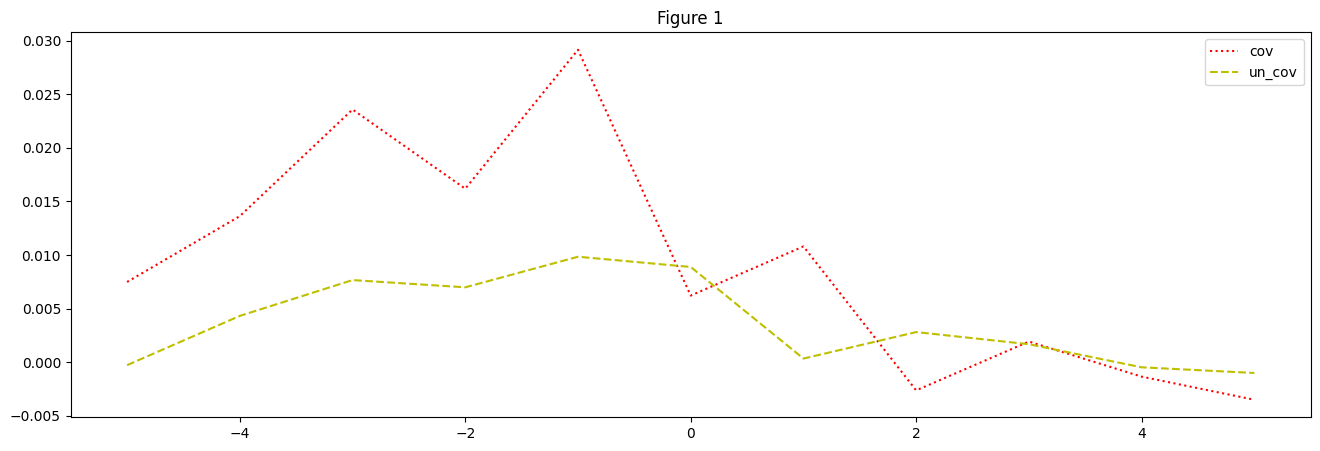

In [13]:
plt.figure(figsize = (16, 5))
plt.title("Figure 1")
cov = calc(d_calc['in_window'] == True)
un_cov = calc(d_calc['in_window'] == False)
plt.plot(cov.iloc[:,0], cov.iloc[:,1], 'r:', label = 'cov')
plt.plot(un_cov.iloc[:,0], un_cov.iloc[:,1], 'y--', label = 'un_cov')
plt.legend()
plt.show()